# Comparison of SBI Algorithms

I want to compare how well the different SBI algorithms work for this problem, so let's give this a try.

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("rocket", n_colors=8)

import numpy as np
import pandas as pd
from tqdm import tnrange, tqdm_notebook

import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm_notebook, tnrange 
import numba
from numba import jit, njit

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator
from stingray.events import EventList

import warnings
warnings.filterwarnings('ignore')

from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst
from stingray import filters

import torch
import sbi.utils as utils
from sbi.inference.base import infer



In [8]:
@jit
def lorentzian(x, amp, x0, fwhm):
    fac1 = amp * (fwhm/2)**2.
    fac2 = (fwhm/2)**2. + (x - x0)**2.
    return fac1/fac2

@jit(nopython=True)
def extract_and_scale(long_lc, red_noise, npoints, mean_counts, rms):
    """
    i) Make a random cut and extract a light curve of required
    length.

    ii) Rescale light curve i) with zero mean and unit standard
    deviation, and ii) user provided mean and rms (fractional
    rms * mean)

    Parameters
    ----------
    long_lc : numpy.ndarray
        Simulated lightcurve of length 'npoints' times 'red_noise'
    
    red_noise : float
        A multiplication factor for the length of the light curve, 
        to deal with red noise leakage
    
    npoints : int
        The total number of data points in the light curve
        
    mean_counts : float
        The mean counts per bin of the light curve to be 
        simulated
        
    rms : float [0, 1]
        The fractional rms amplitude of the variability in the 
        light curve.

    Returns
    -------
    lc : numpy.ndarray
        Normalized and extracted lightcurve of lengtha 'N'
    """
    if red_noise == 1:
        lc = long_lc
    else:
        # Make random cut and extract light curve of length 'N'
        extract = \
            np.random.randint(npoints-1,
                                      red_noise*npoints - npoints+1)
        lc = np.take(long_lc, np.arange(extract, extract + npoints))

    avg = np.mean(lc)
    std = np.std(lc)

    return (lc-avg)/std * mean_counts * rms + mean_counts


@jit(nopython=False)
def simulate_lc(mspec, dt, npoints, mean_counts, rms, tstart = 0.0, red_noise=1.0):
    """
    
    
    
    """

    time = dt*np.arange(npoints) + tstart

    a1 = np.random.normal(size=(2,len(mspec))) * np.sqrt(mspec)

    f = a1[0] + 1j * a1[1]

    f[0] = mean_counts

    # Obtain real valued time series
    f_conj = np.conjugate(np.array(f))

    cts = np.fft.irfft(f_conj, n=npoints)

    lc = Lightcurve(time, extract_and_scale(cts, red_noise, npoints, mean_counts, rms),
                err=np.zeros_like(time) + np.sqrt(mean_counts),
                err_dist='gauss', dt=dt, skip_checks=True)

    return lc

@jit(nopython=True)
def generate_events(time, counts1, counts2):

    cs1 = np.cumsum(counts1)
    cs2 = np.cumsum(counts2)

    times1 = np.zeros(cs1[-1])
    times2 = np.zeros(cs2[-1])

    ncounts = len(counts1)

    for i in range(ncounts):
        times1[cs1[i]:cs1[i+1]] = time[i]
        times2[cs2[i]:cs2[i+1]] = time[i]
        
    return times1, times2

In [9]:
@jit(nopython=False)
def simulate_deadtime(param, freq=None, tseg=10.0, dt_hires=1e-5, dt=0.005, deadtime=0.0025):
    #print("starting function")
    qpo_amp = 1.0 # amplitude of the QPO in CSD
    qpo_rms = param[0] # absolute rms amplitude of the QPO
    qpo_x0 = param[1] # centroid position of the PSD
    qpo_qual = param[2] # quality factor for the QPO
    qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
    mean_cr = param[3] # mean count rate in the light curve

    npoints = int(np.round(tseg/dt_hires)) # total number of points in original light curve

    # count rate in nustar bins
    mean_cr_hires = mean_cr * dt_hires

    if freq is None:
        df_hires = 1.0/tseg # frequency resolution of the PSD/CSD
        fmax_hires = 0.5/dt_hires # maximum frequency in the CSD/PSD

        # list of frequencies
        freq = np.arange(df_hires, fmax_hires+df_hires, df_hires)

    # generate theoretical spectrum
    mspec = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

    #print("simulating light curves")
    lc = simulate_lc(mspec, dt_hires, npoints, mean_cr_hires, qpo_rms)
    lc.counts[lc.counts < 0] = 0.0

    #print("applying counts")
    # apply counts
    counts1 = np.random.poisson(lc.counts)
    counts2 = np.random.poisson(lc.counts)

    counts_total = counts1 + counts2

    #print("generating events")
    times1, times2 = generate_events(lc.time, counts1, counts2)

    #print("deadtime filtering")
    mask1 = filters.get_deadtime_mask(times1, deadtime, return_all=False)
    mask2 = filters.get_deadtime_mask(times2, deadtime, return_all=False)

    times1_dt = times1[mask1]
    times2_dt = times2[mask2]
    
    #print("generating light curves")
    lc1 = Lightcurve.make_lightcurve(times1, dt=dt, tseg=tseg, tstart=0.0)
    lc1_dt = Lightcurve.make_lightcurve(times1_dt, dt=dt, tseg=tseg, tstart=0.0)

    lc2 = Lightcurve.make_lightcurve(times2, dt=dt, tseg=tseg, tstart=0.0)
    lc2_dt = Lightcurve.make_lightcurve(times2_dt, dt=dt, tseg=tseg, tstart=0.0)

    #lc_sim = lc1 + lc2
    #lc_sim_dt = lc1_dt + lc2_dt

    #print("generating PSDS")
    #ps_sim = Powerspectrum(lc_sim, norm="frac")
    #ps_sim_dt = Powerspectrum(lc_sim_dt, norm="frac")

    #cs_sim = Crossspectrum(lc1, lc2, norm="frac")
    #cs_sim_dt = Crossspectrum(lc1_dt, lc2_dt, norm="frac")

    #print("... and done")
    return lc1, lc2, lc1_dt, lc2_dt

In [10]:
np.random.seed(20201204)

qpo_amp = 1.0 # QPO amplitude, in reality set by the RMS
qpo_x0 = 20.0 # centroid frequency of the QPO, in Hz
qpo_qual = 10.0 # quality factor of the QPO, i.e. centroid / fwhm
qpo_fwhm = qpo_x0/qpo_qual # full-width half-maximum of the Lorentzian

rms_obs = 0.4 # fractional RMS amplitude of the QPO

tseg = 10.0 # total duration in seconds
dt_nustar = 1e-5 # time resolution of NuSTAR
dt = 0.5/100.0 # time step of the output light curve
npoints = int(np.round(tseg/dt_nustar)) # total number of points in original light curve

mean_countrate_obs = 1000
mean_counts_nustar_obs = mean_countrate_obs * dt_nustar

df_nustar = 1.0/tseg # frequency resolution of the PSD/CSD
fmax_nustar = 0.5/dt_nustar # maximum frequency in the CSD/PSD

# dead time for nustar
deadtime_nustar = 0.0025

# list of frequencies
freq = np.linspace(df_nustar, fmax_nustar, num=npoints//2)

# generate theoretical spectrum
mspec_obs = lorentzian(freq, qpo_amp, qpo_x0, qpo_fwhm)

# store parameters in a list for easy (plotting) access
param_obs = [rms_obs, qpo_x0, qpo_qual, mean_countrate_obs]

# generate some ligth curves, both with (*_dt) and without dead time
lc1_obs, lc2_obs, lc1_obs_dt, lc2_obs_dt = simulate_deadtime(param_obs, 
                                                             freq=freq, 
                                                             tseg=tseg, 
                                                             dt_hires=dt_nustar, 
                                                             dt=dt, 
                                                             deadtime=deadtime_nustar)

In [11]:
lc_obs = lc1_obs + lc2_obs
lc_obs_dt = lc1_obs_dt + lc2_obs_dt

ps_obs = Powerspectrum(lc_obs, norm="frac")
ps_obs_dt = Powerspectrum(lc_obs_dt, norm="frac")

cs_obs = Crossspectrum(lc1_obs, lc2_obs, norm="frac")
cs_obs_dt = Crossspectrum(lc1_obs_dt, lc2_obs_dt, norm="frac")

<IPython.core.display.Javascript object>


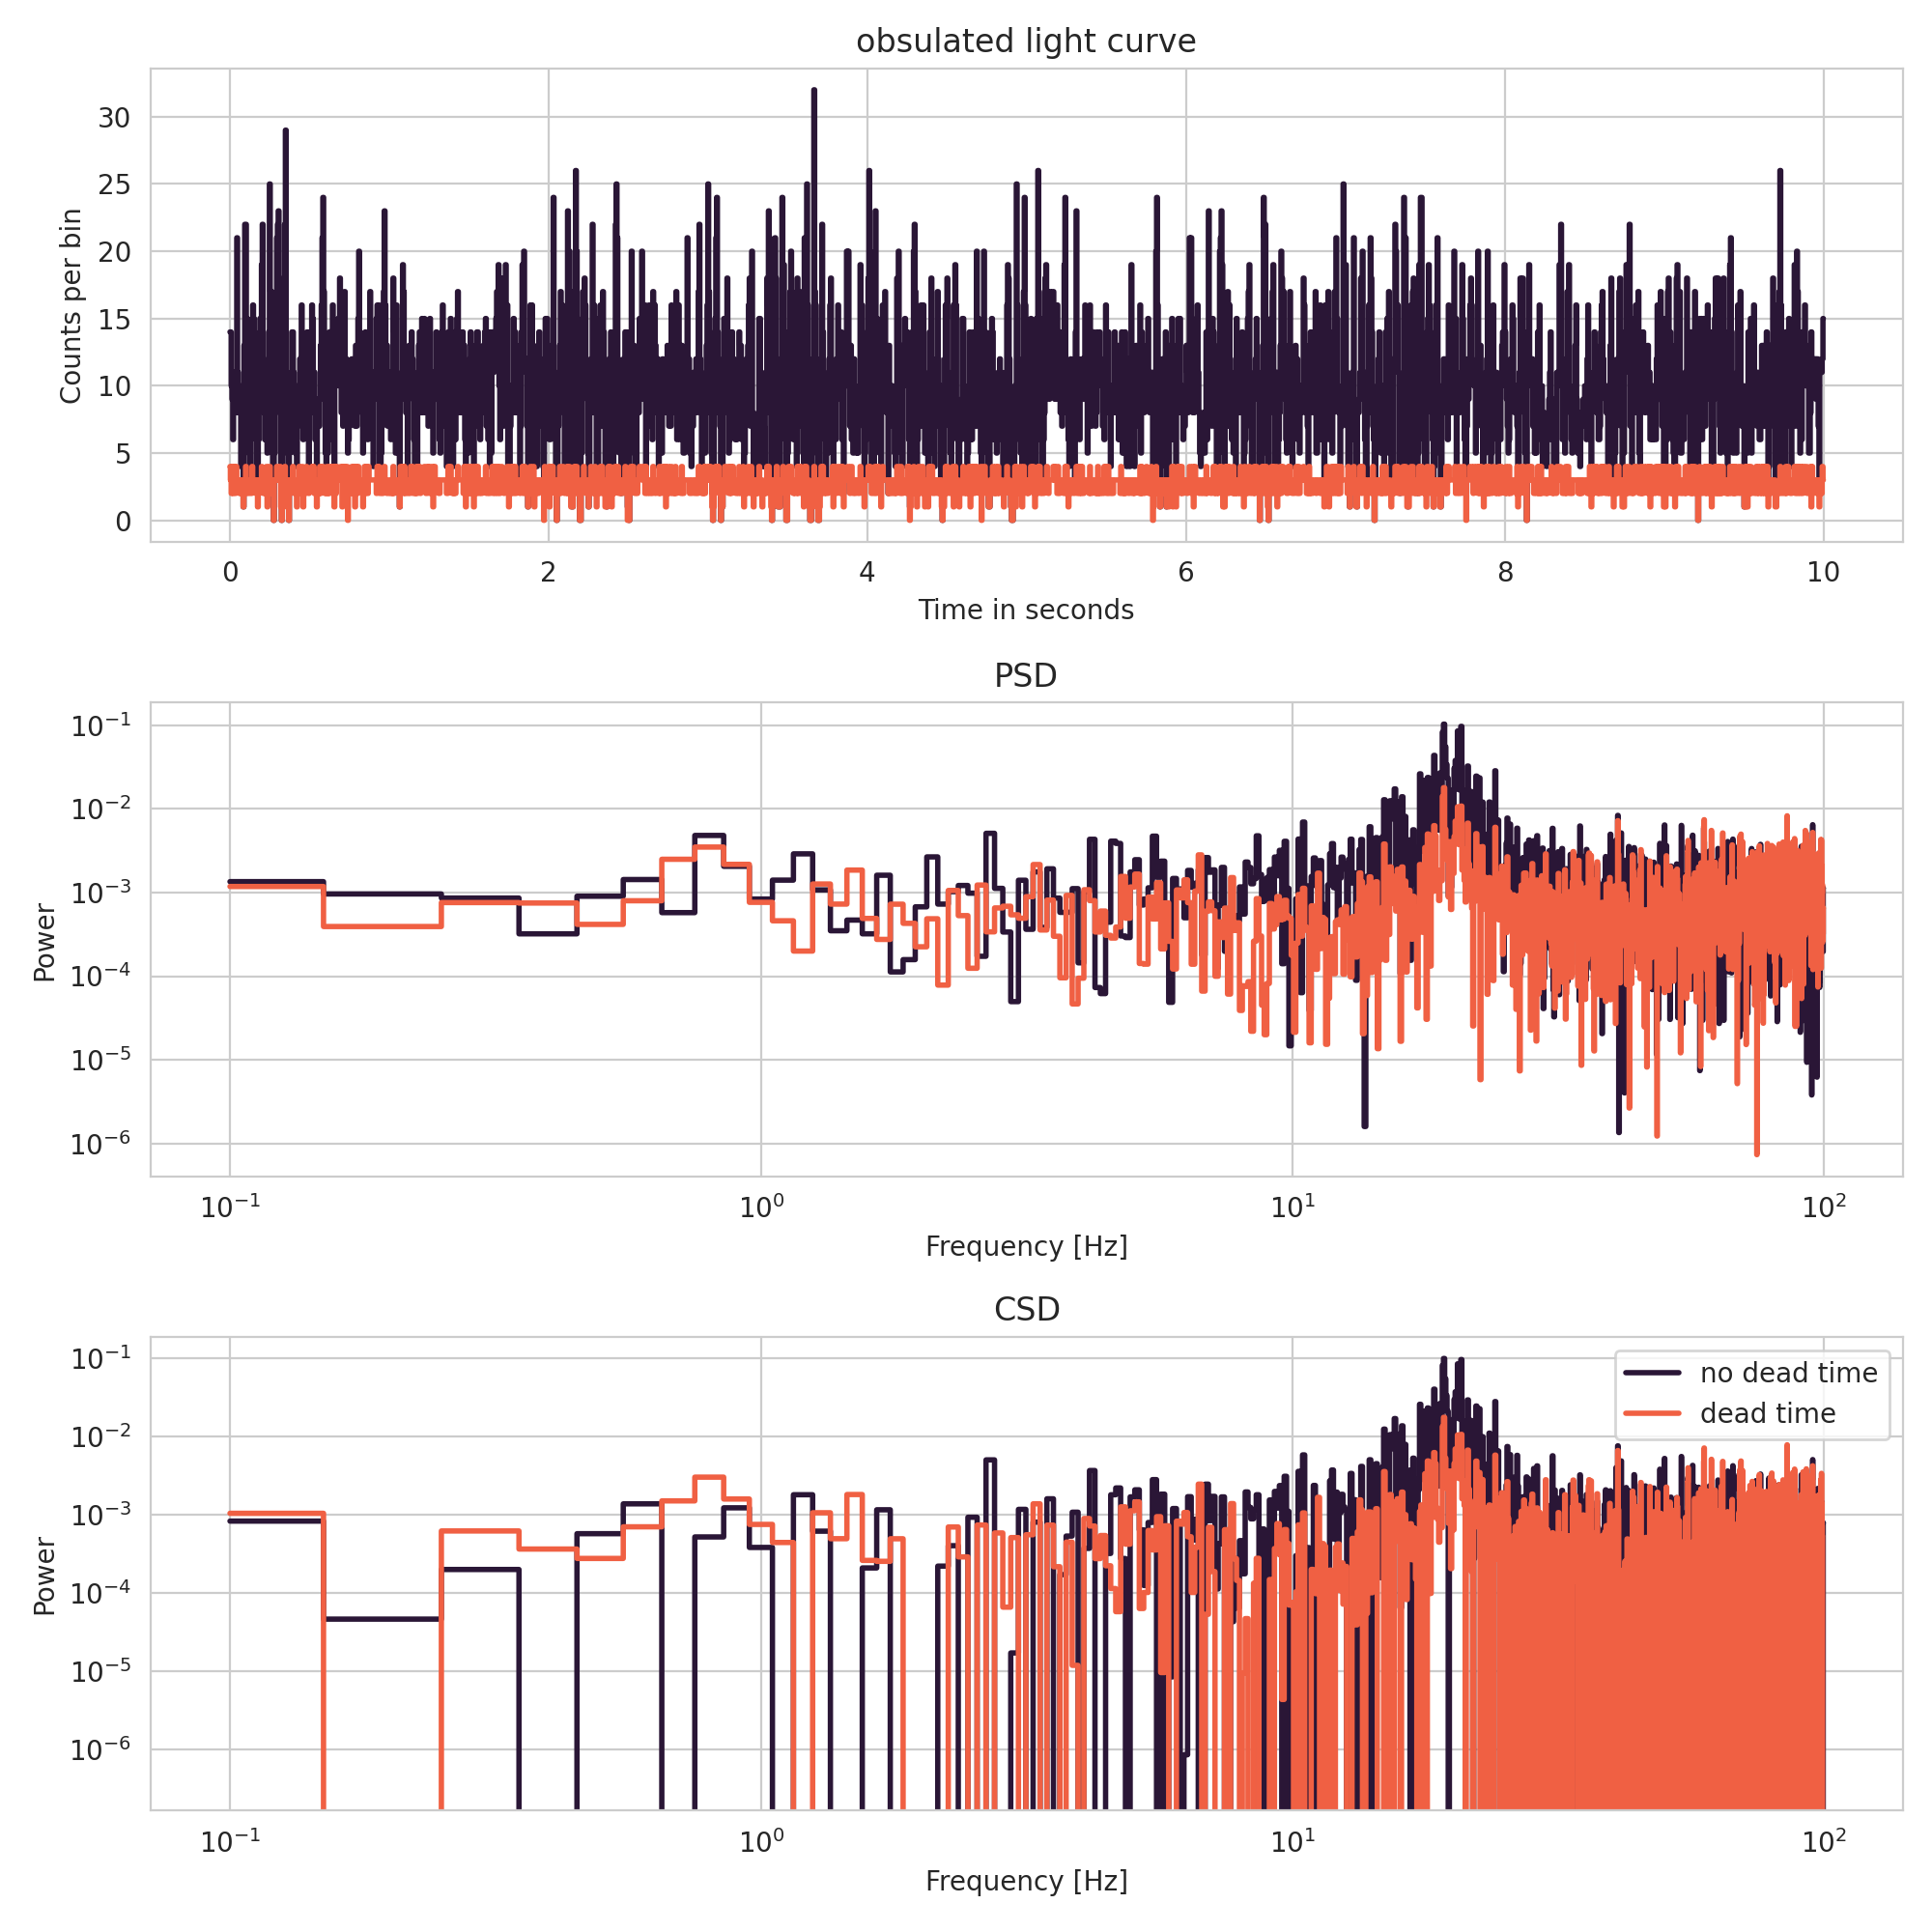

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10))

c1 = sns.color_palette()[0]
c2 = sns.color_palette()[5]

ax1.plot(lc_obs.time, lc_obs.counts, ds="steps-mid", lw=2, label="no dead time", c=c1)
ax1.plot(lc_obs_dt.time, lc_obs_dt.counts, ds="steps-mid", lw=2, label="dead time", c=c2)
ax1.set_xlabel("Time in seconds")
ax1.set_ylabel("Counts per bin")
ax1.set_title("obsulated light curve")

ax2.loglog(ps_obs.freq, ps_obs.power, lw=2, ds="steps-mid", label="no dead time", c=c1)
ax2.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, ds="steps-mid", label="dead time", c=c2)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Power")
ax2.set_title("PSD")

ax3.loglog(cs_obs.freq, cs_obs.power, lw=2, ds="steps-mid", label="no dead time", c=c1)
ax3.loglog(cs_obs_dt.freq, cs_obs_dt.power, lw=2, ds="steps-mid", label="dead time", c=c2)
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Power")
ax3.set_title("CSD")

ax3.legend()

plt.tight_layout()

In [13]:

def generate_simulator_function(tseg=10.0, dt_hires=1e-5, dt=0.005, 
                                deadtime=0.0025, segment_size=1.0, summary_type="psd", f=0.01):
    def simulation(param):
        """
        Generate a simulated data set with a single QPO given a parameter set.

        Parameters
        ----------
        param : iterable
            A list of parameters:
                * Fractional RMS amplitude of the QPO
                * centroid position x0 of teh QPO
                * quality factor (x0/fwhm) of the QPO
                * average count rate of the light curve

        summary_type:
            What to return as a summary. Options are
                * "psd": return the unaveraged powers in the PSD
                * "avg": return averaged PSD, requires `segment_size`

        Returns
        -------
        summary : np.ndarray
            An array of summary statistics

        """

        param = np.array(param)
        #param = [rms, x0, qual, mean_cr]
        qpo_rms = param[0] # absolute rms amplitude of the QPO
        qpo_x0 = param[1] # centroid position of the PSD
        qpo_qual = param[2] # quality factor for the QPO
        qpo_fwhm = qpo_x0 / qpo_qual # Lorentzian FWHM, calculated from centroid and quality factor
        mean_cr = param[3] # mean count rate in the light curve


        lc1, lc2, lc1_dt, lc2_dt = simulate_deadtime(param, 
                                                     freq=None, 
                                                     tseg=tseg, 
                                                     dt_hires=dt_hires, 
                                                     dt=dt, 
                                                     deadtime=deadtime)


        if summary_type == "psd":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            return torch.as_tensor(ps.power)
        elif summary_type == "avg":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, norm="frac")
            return torch.as_tensor(aps.power)
        elif summary_type == "csd":
            cs = Crossspectrum(lc1_dt, lc2_dt, norm="frac")
            return torch.as_tensor(cs.power)
        elif summary_type == "logbin":
            ps = Powerspectrum(lc1_dt+lc2_dt, norm="frac")
            ps_bin = ps.rebin_log(f)
            return torch.as_tensor(ps_bin.power)
        elif summary_type == "avglogbin":
            aps = AveragedPowerspectrum(lc1_dt+lc2_dt, segment_size, 
                                        norm="frac", silent=True)
            aps_bin = aps.rebin_log(f)
            return torch.as_tensor(aps_bin.power)
        else:
            raise ValueError("Type of summary to be returned not recognized!")
            
    return simulation

In [14]:
lower_bounds = torch.tensor([0.1, 5.0, 3.0, 500])
upper_bounds = torch.tensor([0.5, 40.0, 30.0, 1500.0])

prior = utils.BoxUniform(
        low = lower_bounds,
        high = upper_bounds
        )
simulation_kwargs = {"tseg":10.0, "dt_hires":1e-5, "dt":0.5/100.0, "deadtime":0.0025, "summary_type":"psd"}
simulator = generate_simulator_function(**simulation_kwargs)

We're going to try all three algorithms:

## Sequential Neural Posterior Estimation

Let's try to infer the whole posterior to start. This is great because once 
it's trained, inference is lightning fast:


Neural network successfully converged after 25 epochs.


<IPython.core.display.Javascript object>


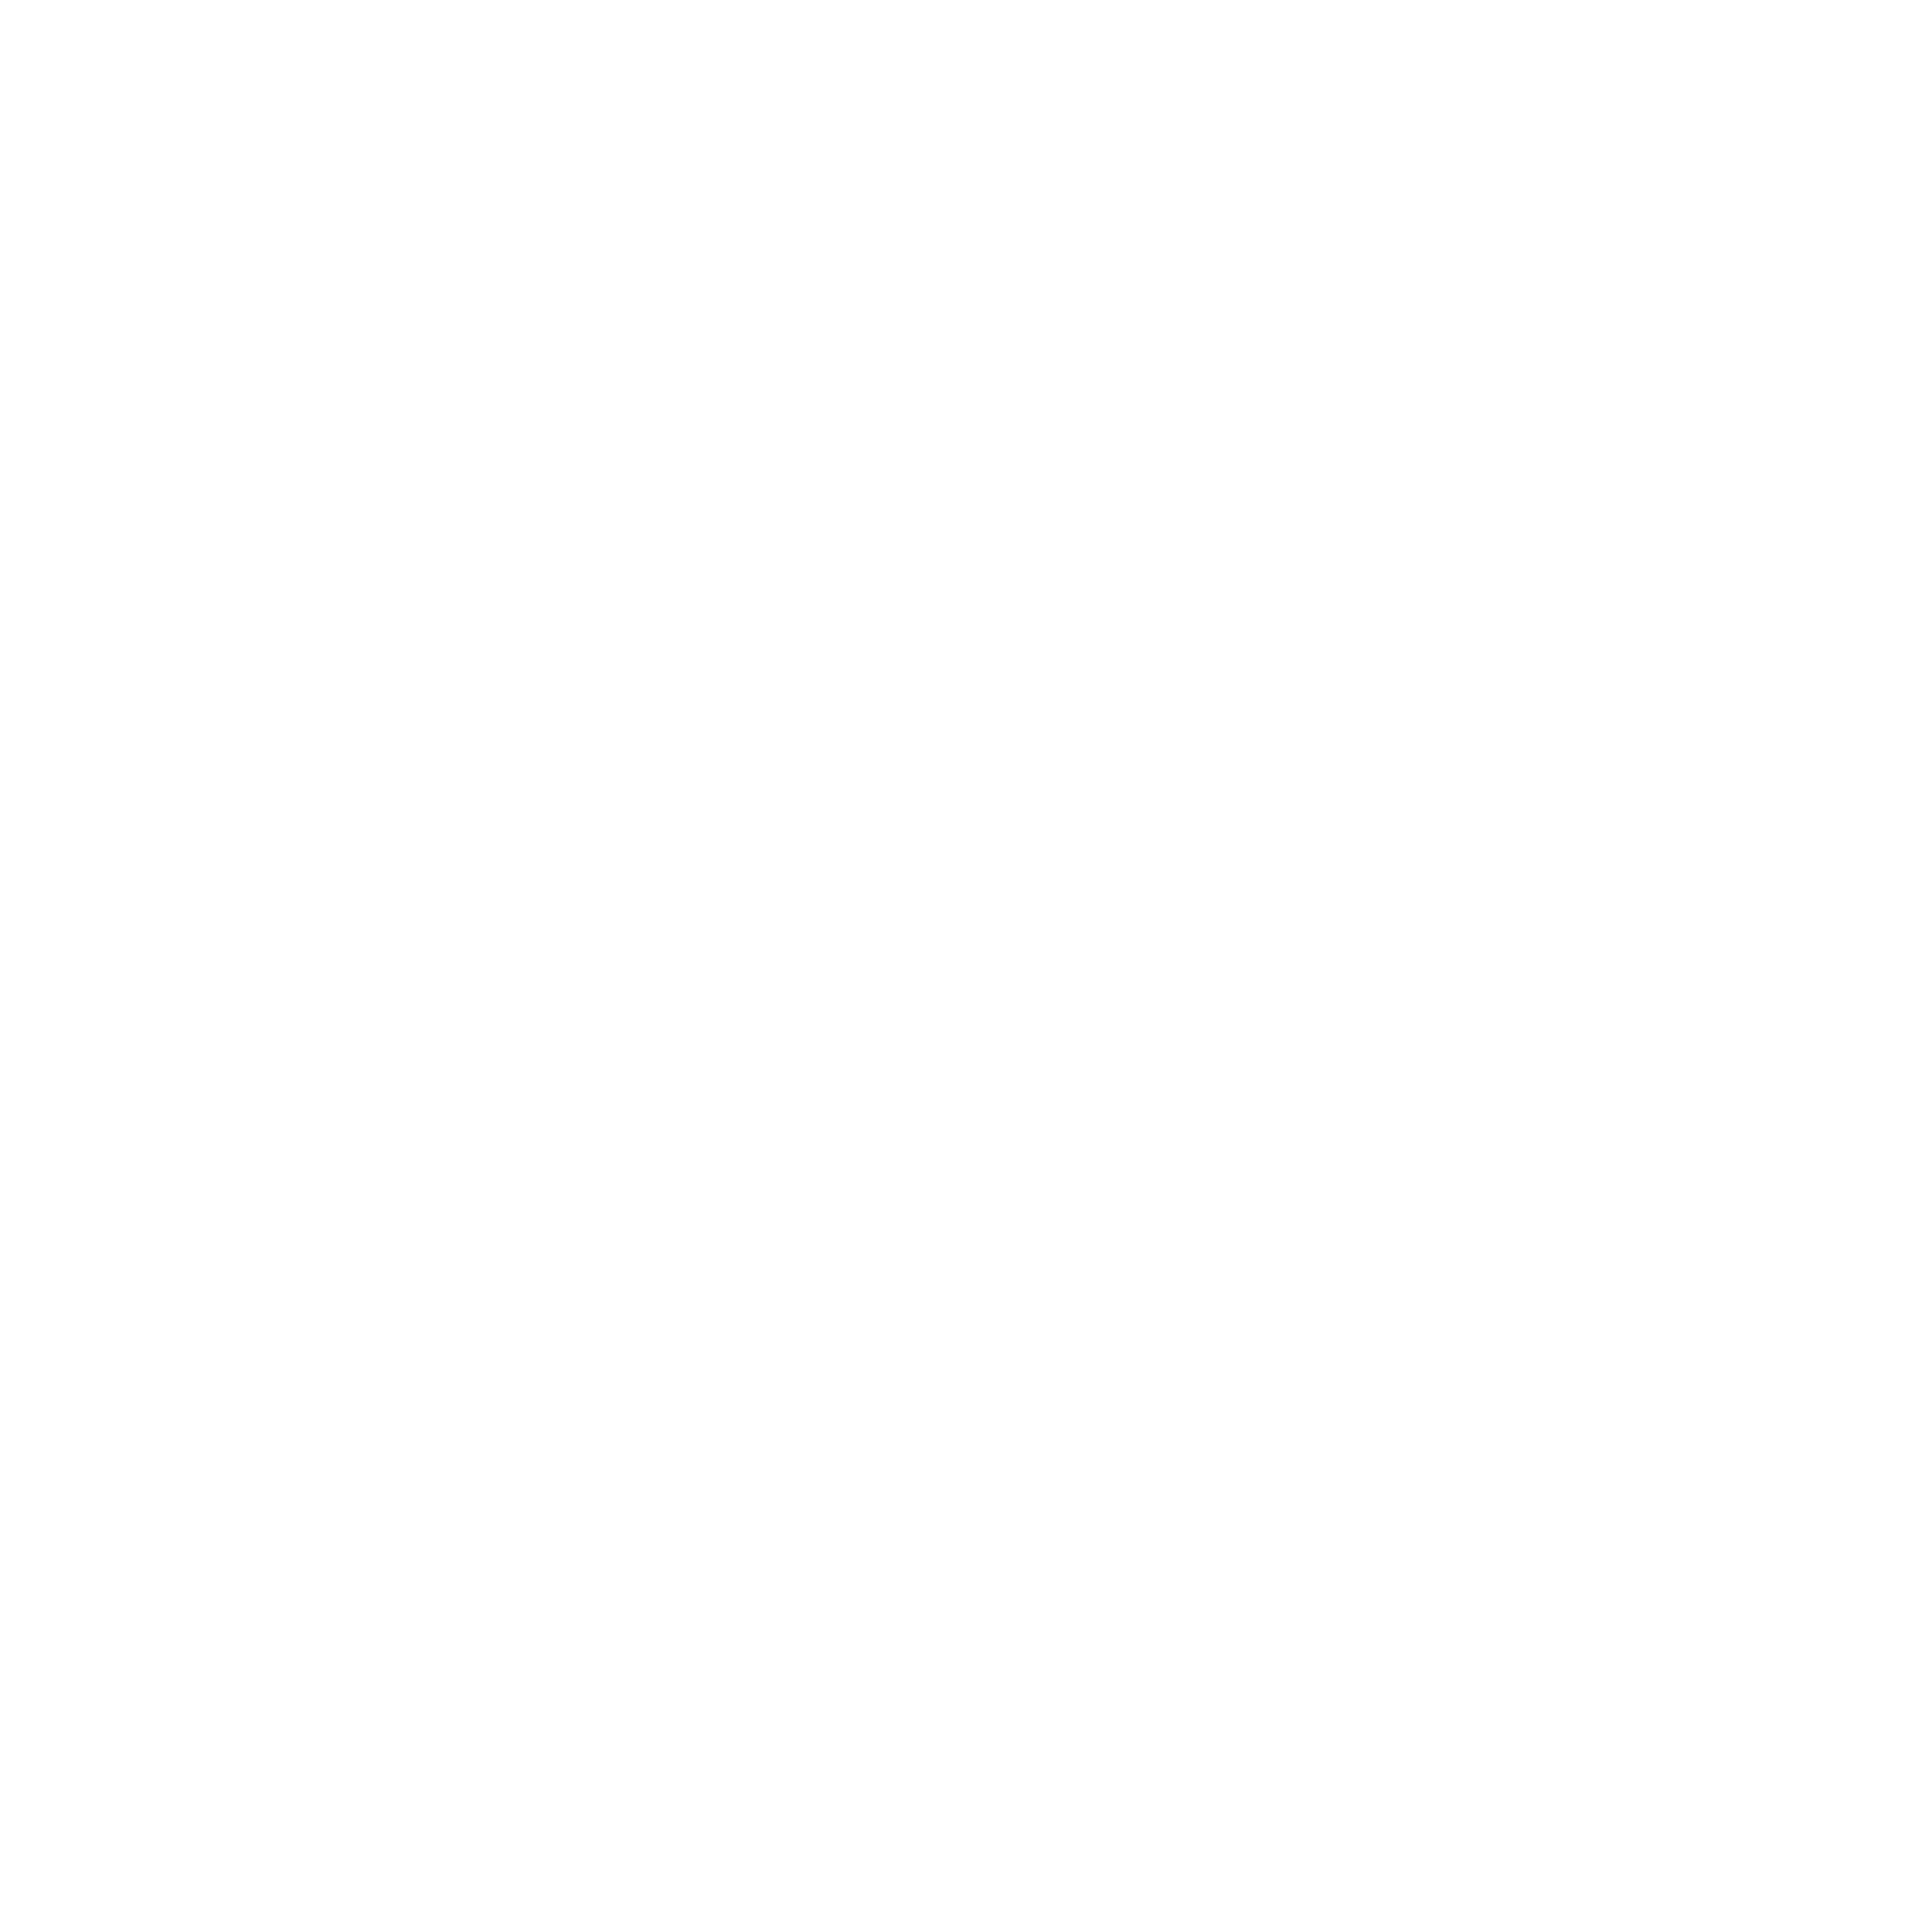

In [34]:
num_sim = 20000
method = "SNPE"

post_snpe = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

In [35]:
samples_snpe = post_snpe.sample((20000,), 
                           x=torch.as_tensor(ps_obs_dt.power))


<IPython.core.display.Javascript object>


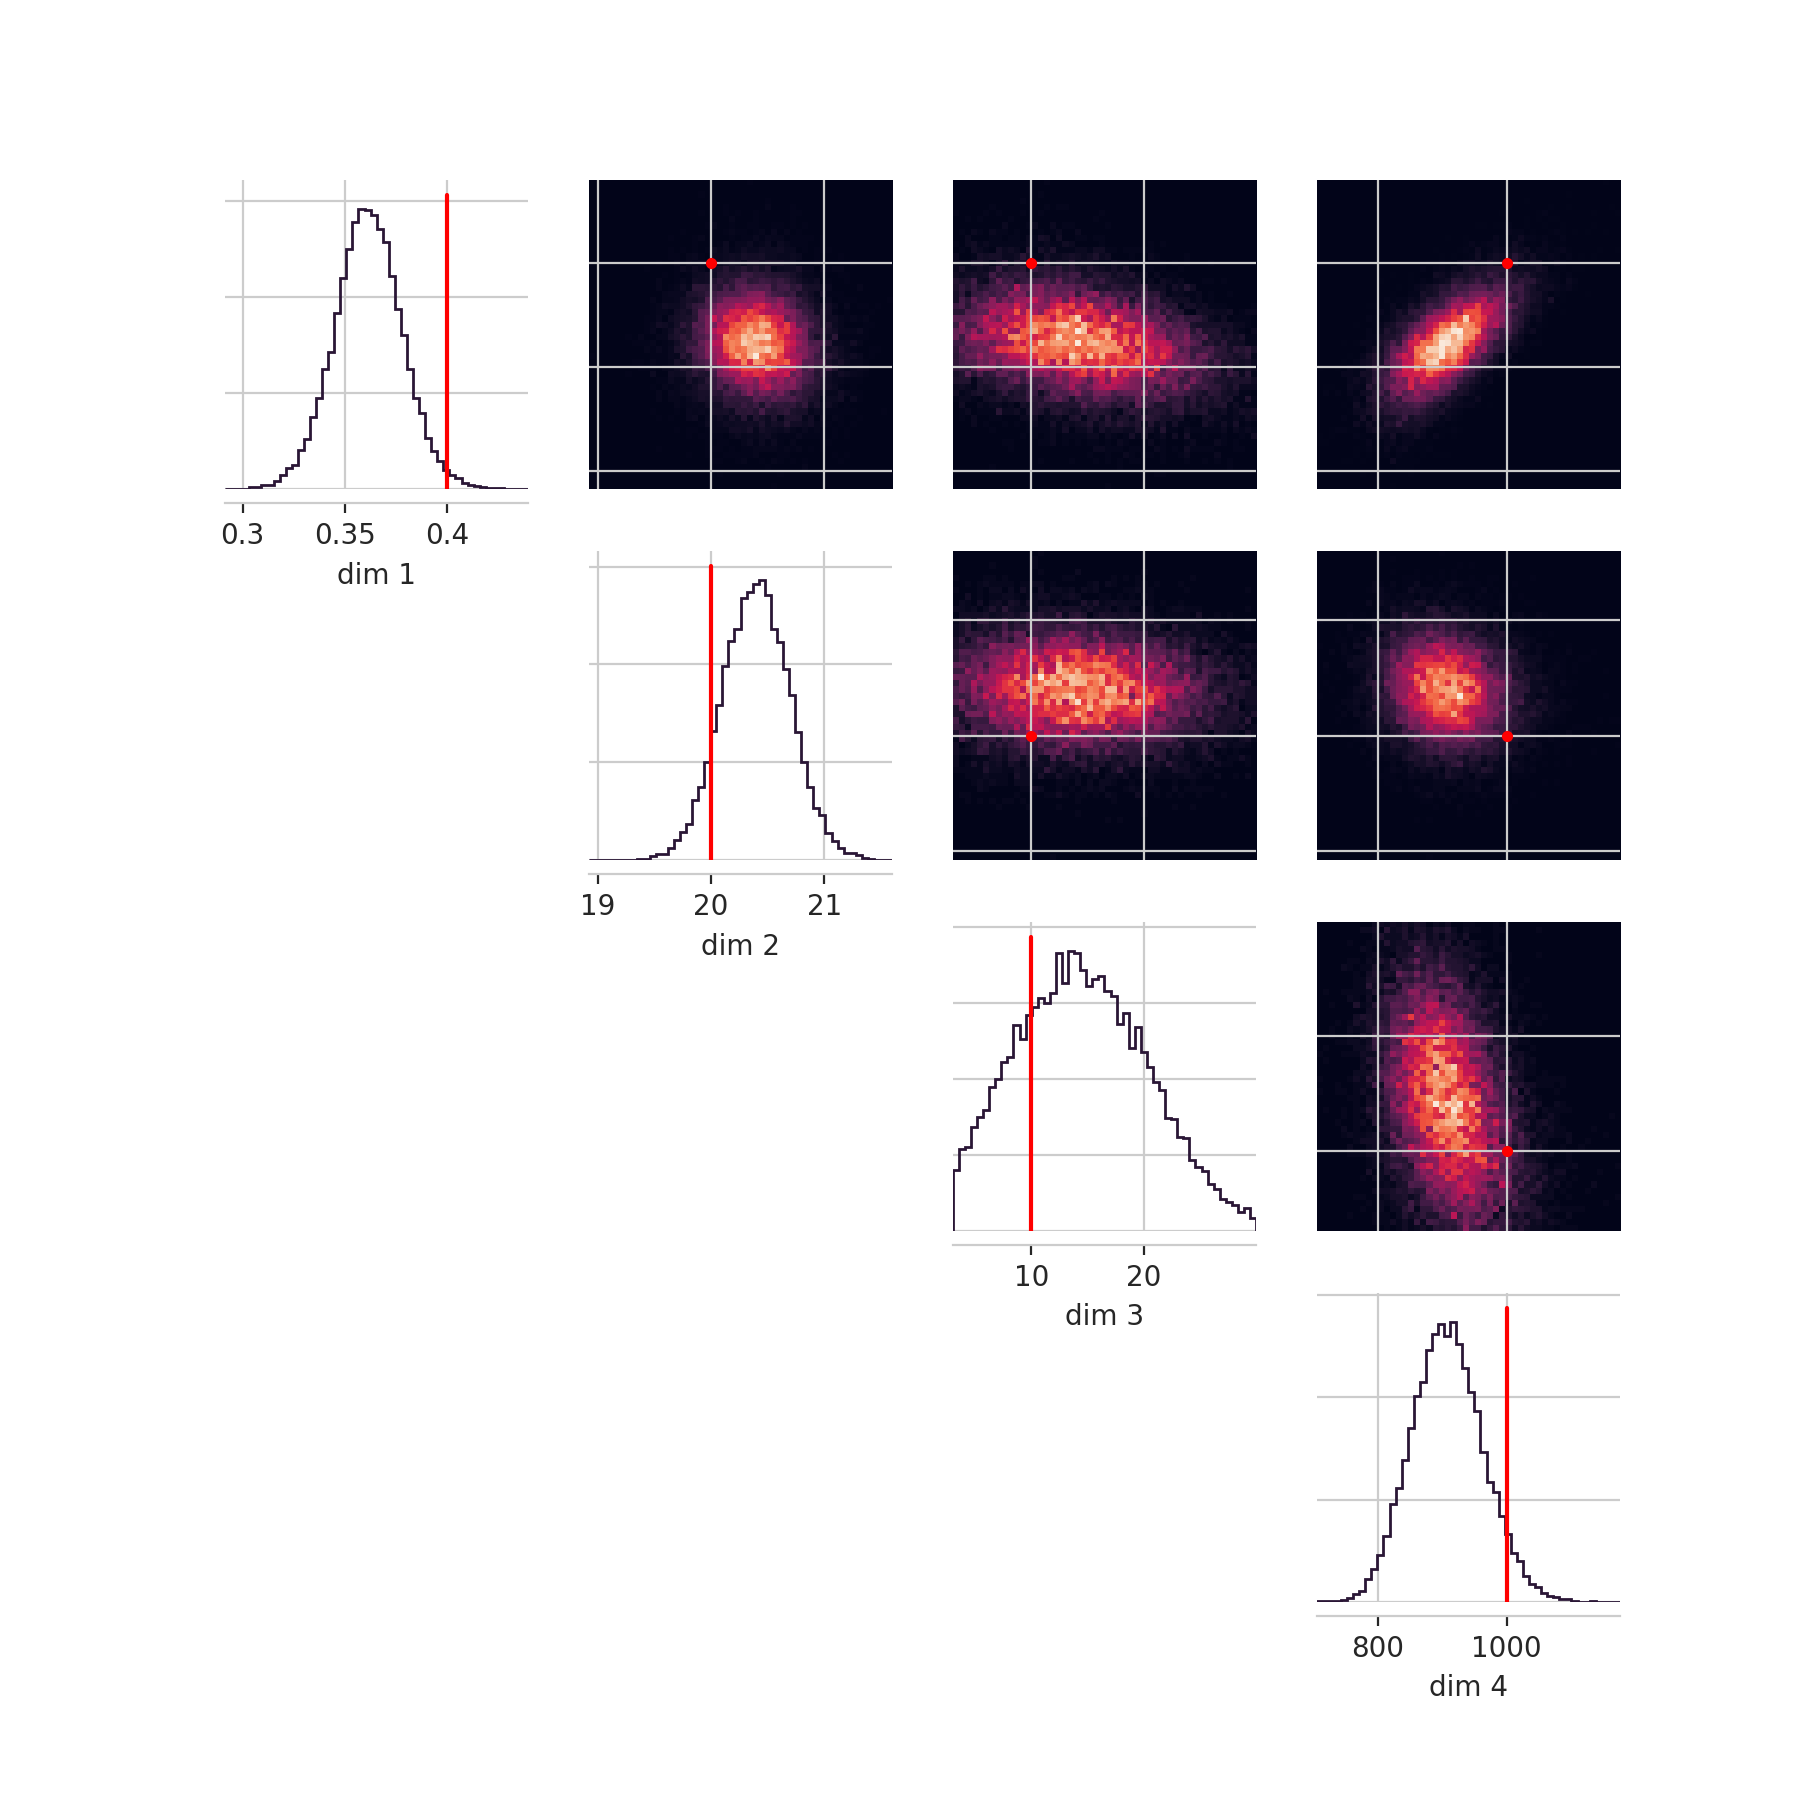

In [40]:
fig, axes = utils.pairplot(samples_snpe,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors='r');





<IPython.core.display.Javascript object>


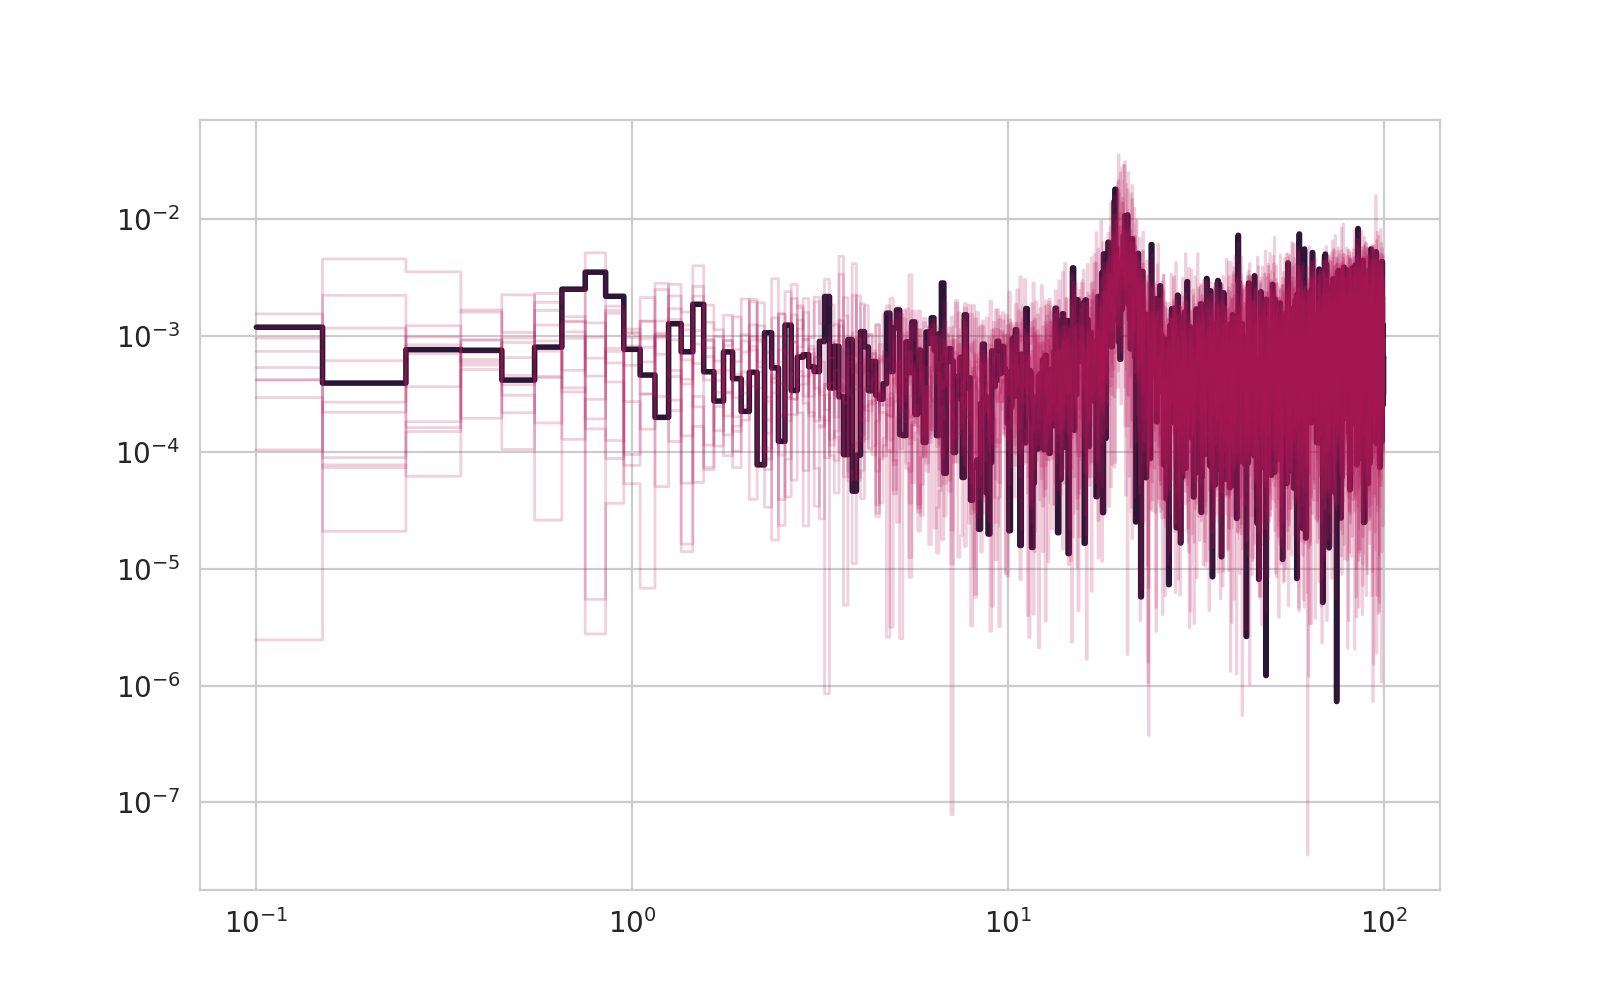

In [41]:
pal = sns.color_palette()

samples_snpe = np.array(samples_snpe)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples_snpe[i,:]
    ps_sim = np.array(simulator(param_sim))
    
    ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    

We're going to try all three algorithms:

## Sequential Neural Likelihood Estimation

Let's try to infer the only the likelihood to start. This allows inference with 
multiple different priors, and comparison between priors, but means the sampling 
is much slower, because it requires another MCMC step:


Neural network successfully converged after 93 epochs.


<IPython.core.display.Javascript object>


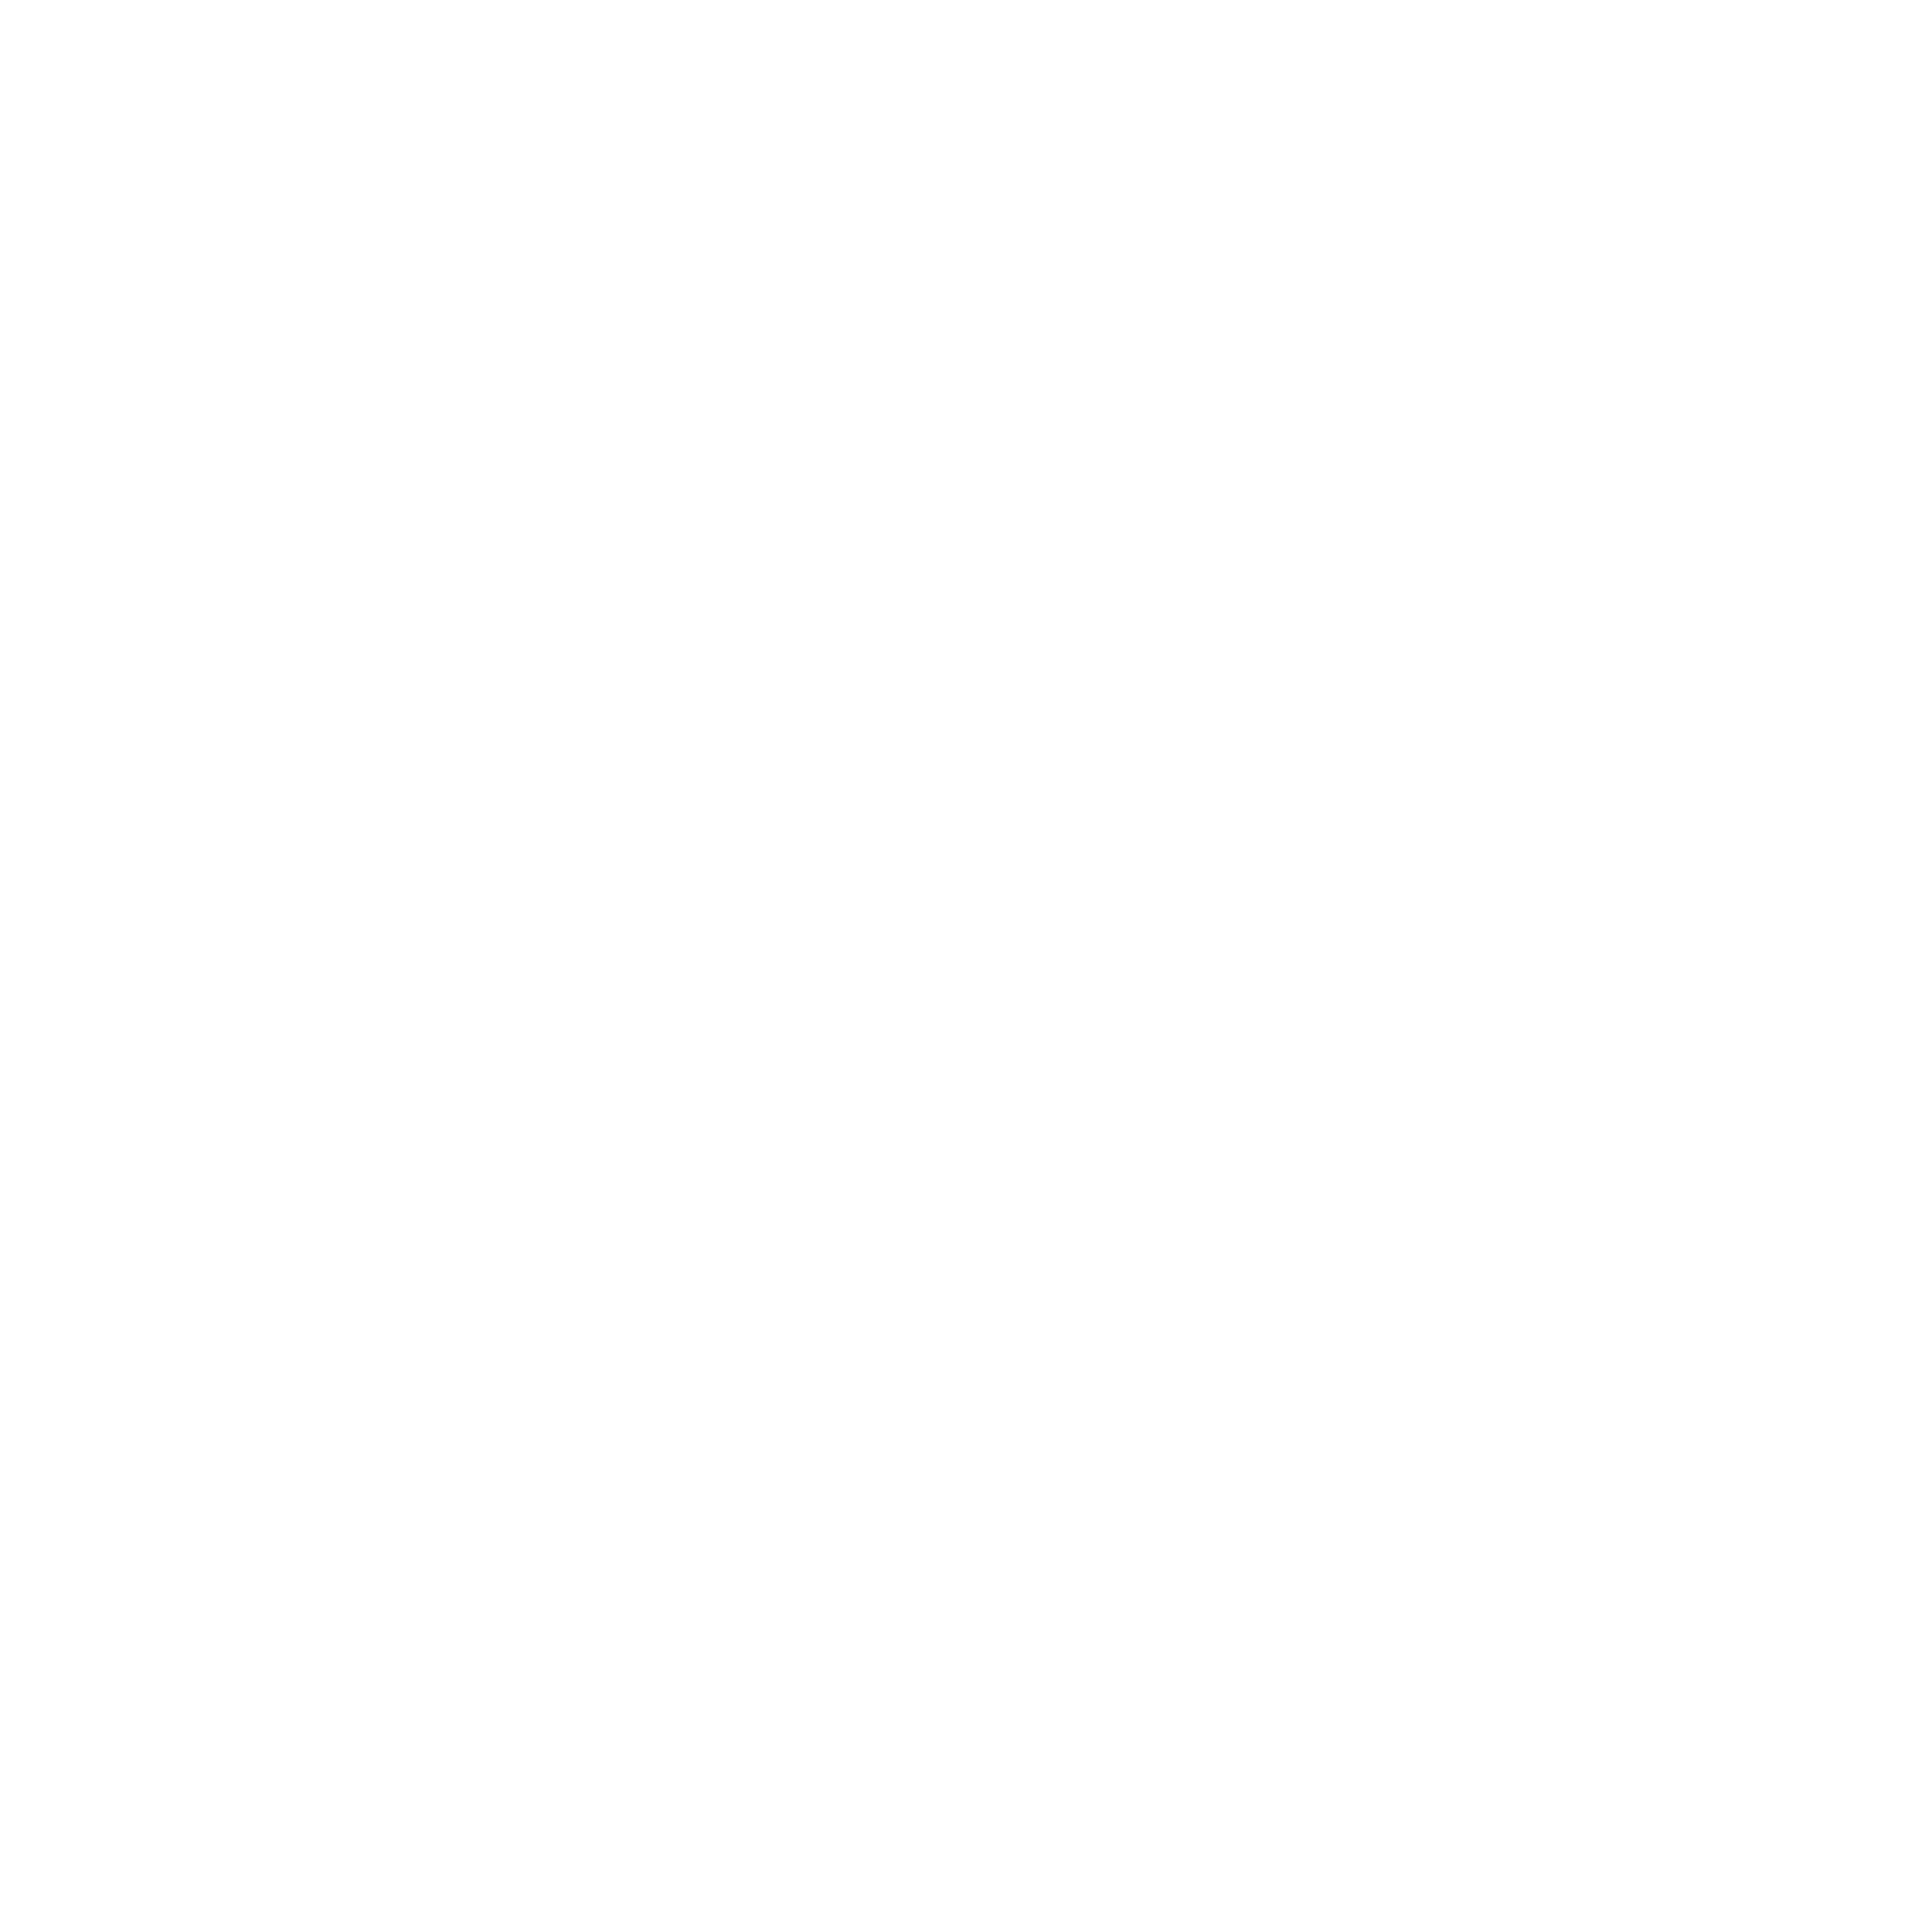

In [42]:
num_sim = 20000
method = "SNLE"

post_snle = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

In [43]:
samples_snle = post_snle.sample((500,), 
                           x=torch.as_tensor(ps_obs_dt.power))


Generating samples: 100%|██████████| 500/500 [12:10<00:00,  1.46s/it]


<IPython.core.display.Javascript object>


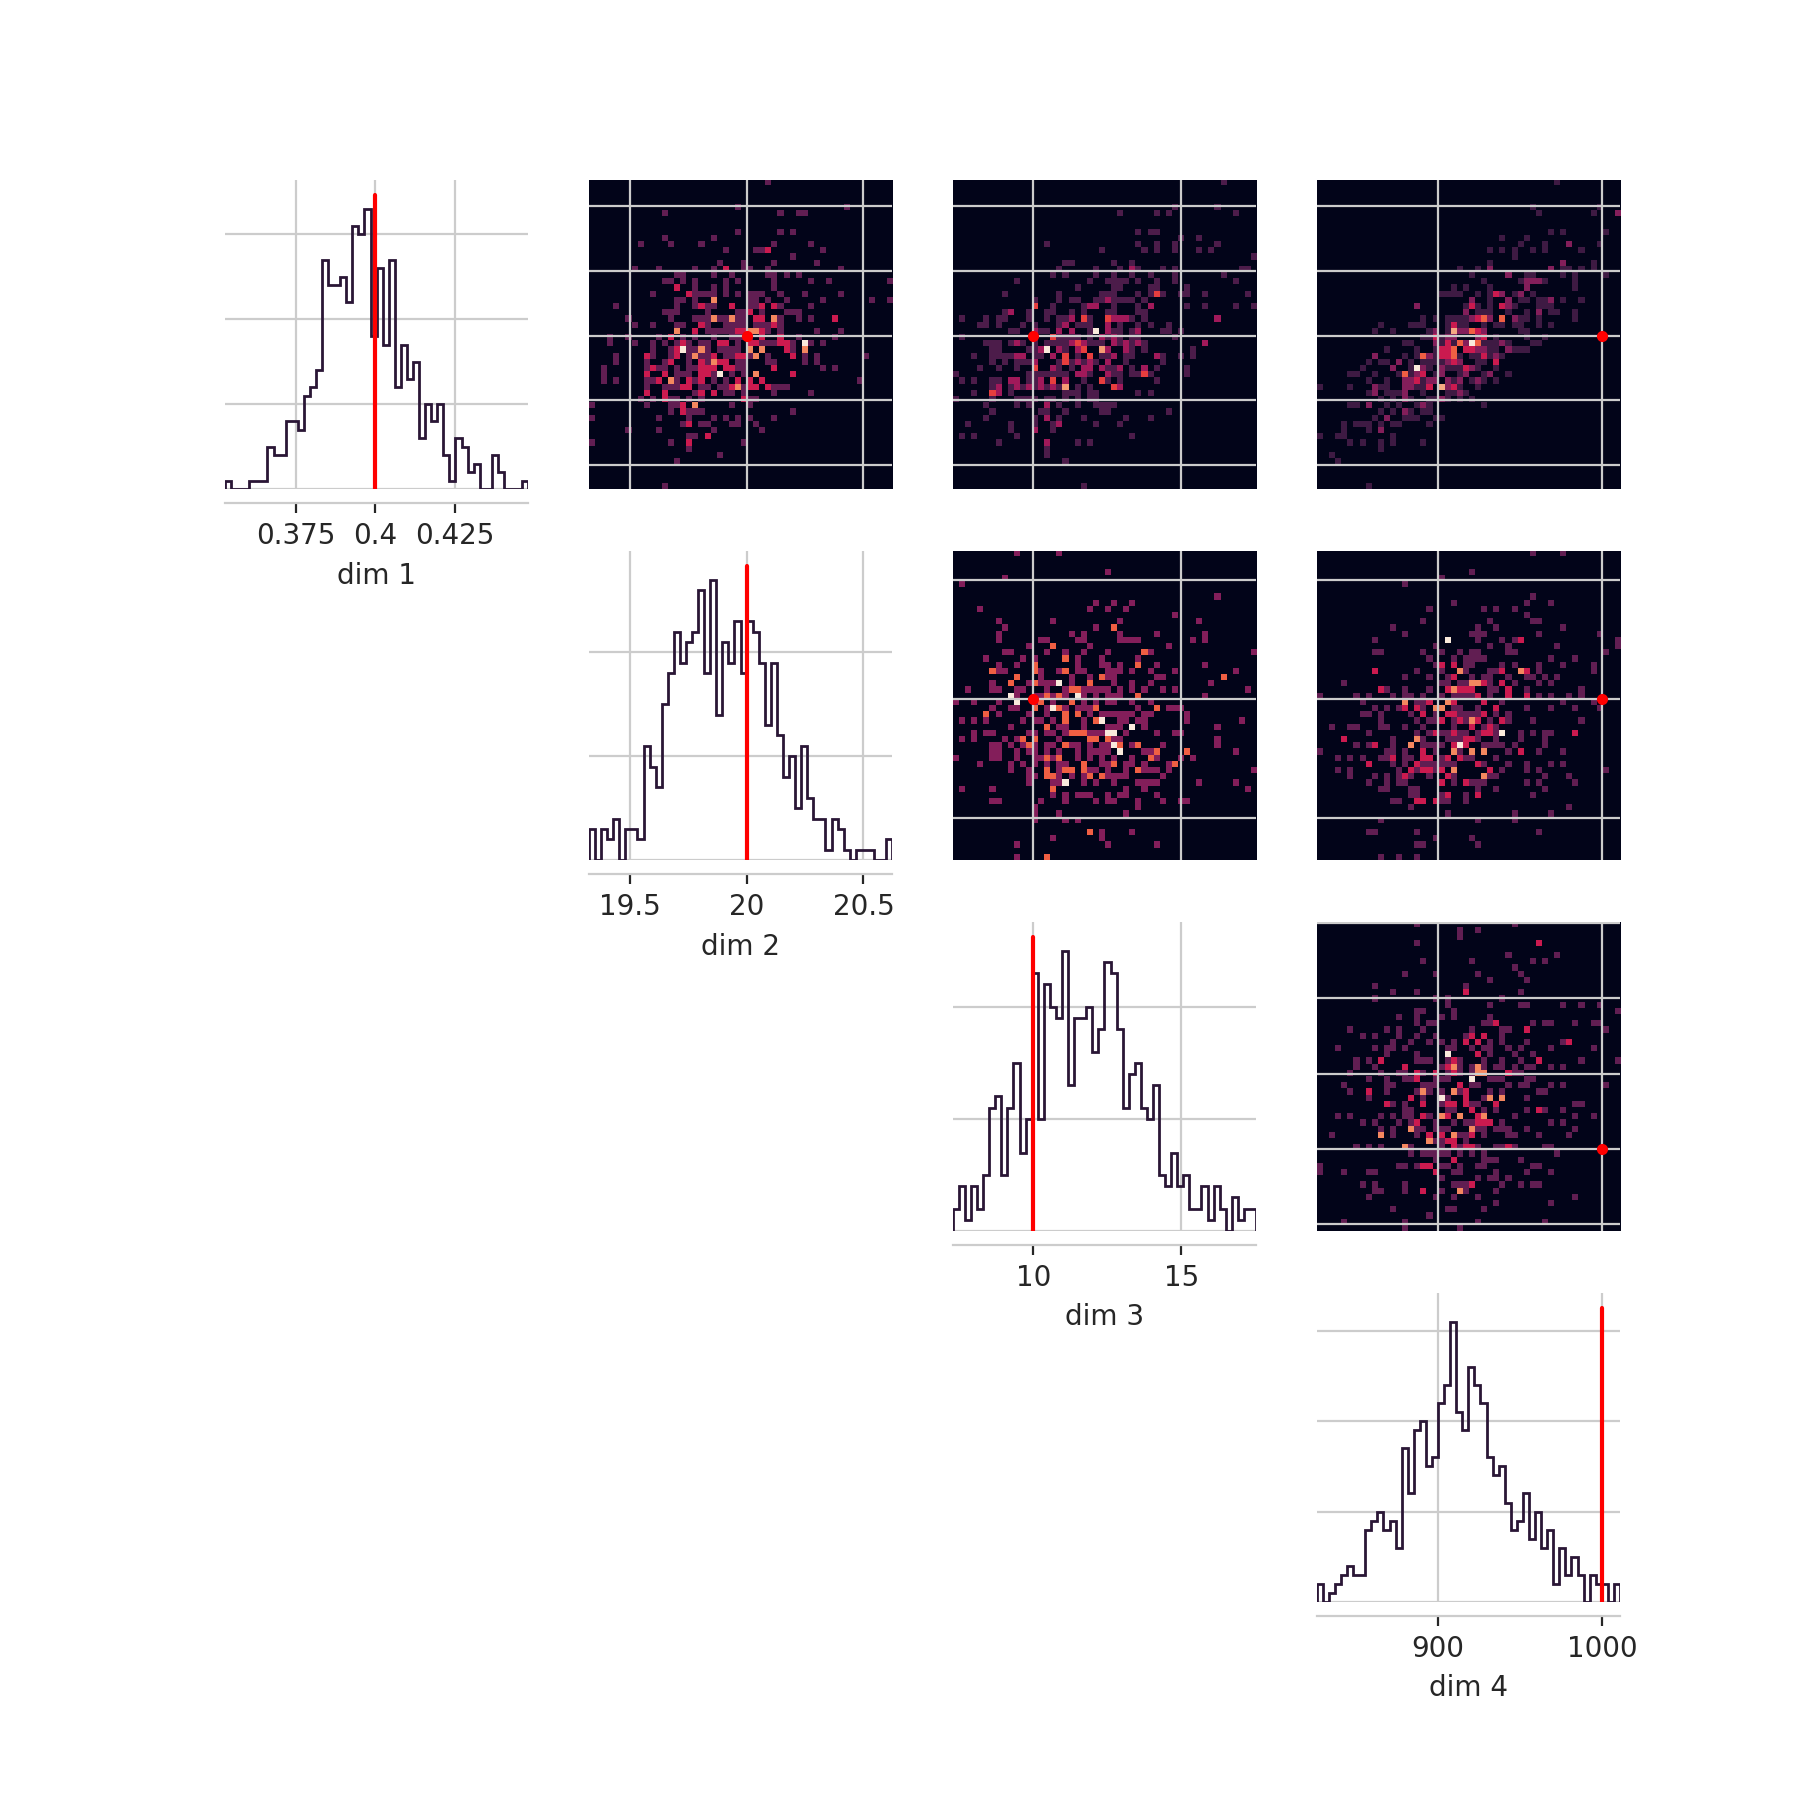

In [44]:
fig, axes = utils.pairplot(samples_snle,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors='r');





<IPython.core.display.Javascript object>


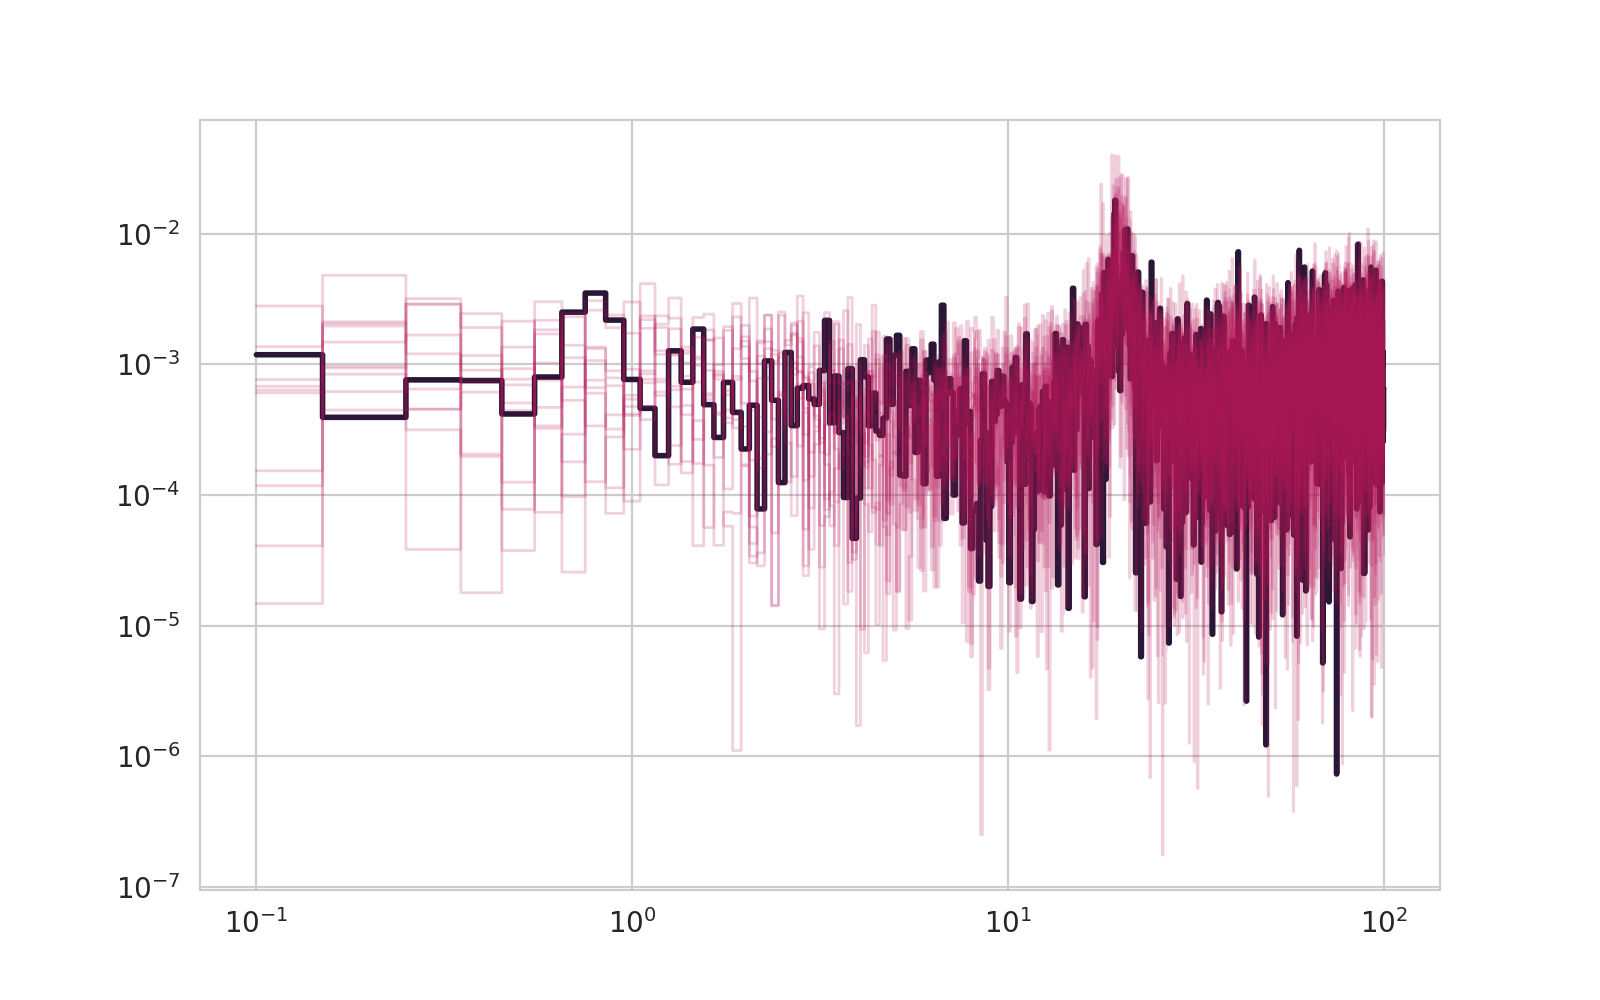

In [45]:
pal = sns.color_palette()

samples = np.array(samples_snle)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples_snle.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples_snle[i,:]
    ps_sim = np.array(simulator(param_sim))
    
    ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    

We're going to try all three algorithms:

## Sequential Neural Likelihood Ratio Estimation

Some speed-up can be gained by inferring likelihood *ratios* rather than likelihoods. 
I don't really know what this means. I should check. 


Neural network successfully converged after 97 epochs.


<IPython.core.display.Javascript object>


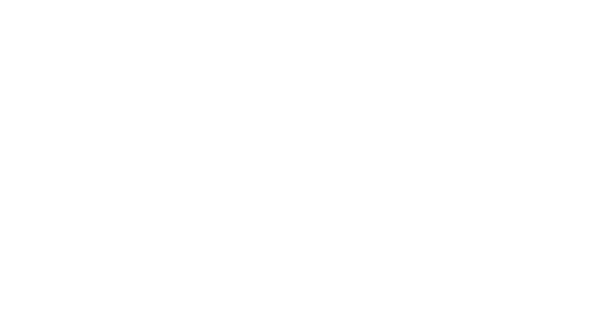

In [47]:
num_sim = 20000
method = "SNRE"

post_snre = infer(
        simulator,
        prior,
        method=method,
        num_workers = -1,
        num_simulations=num_sim
)

In [48]:
samples_snre = post_snre.sample((600,), 
                           x=torch.as_tensor(ps_obs_dt.power))


Generating samples: 100%|██████████| 600/600 [01:38<00:00,  6.11it/s]


<IPython.core.display.Javascript object>


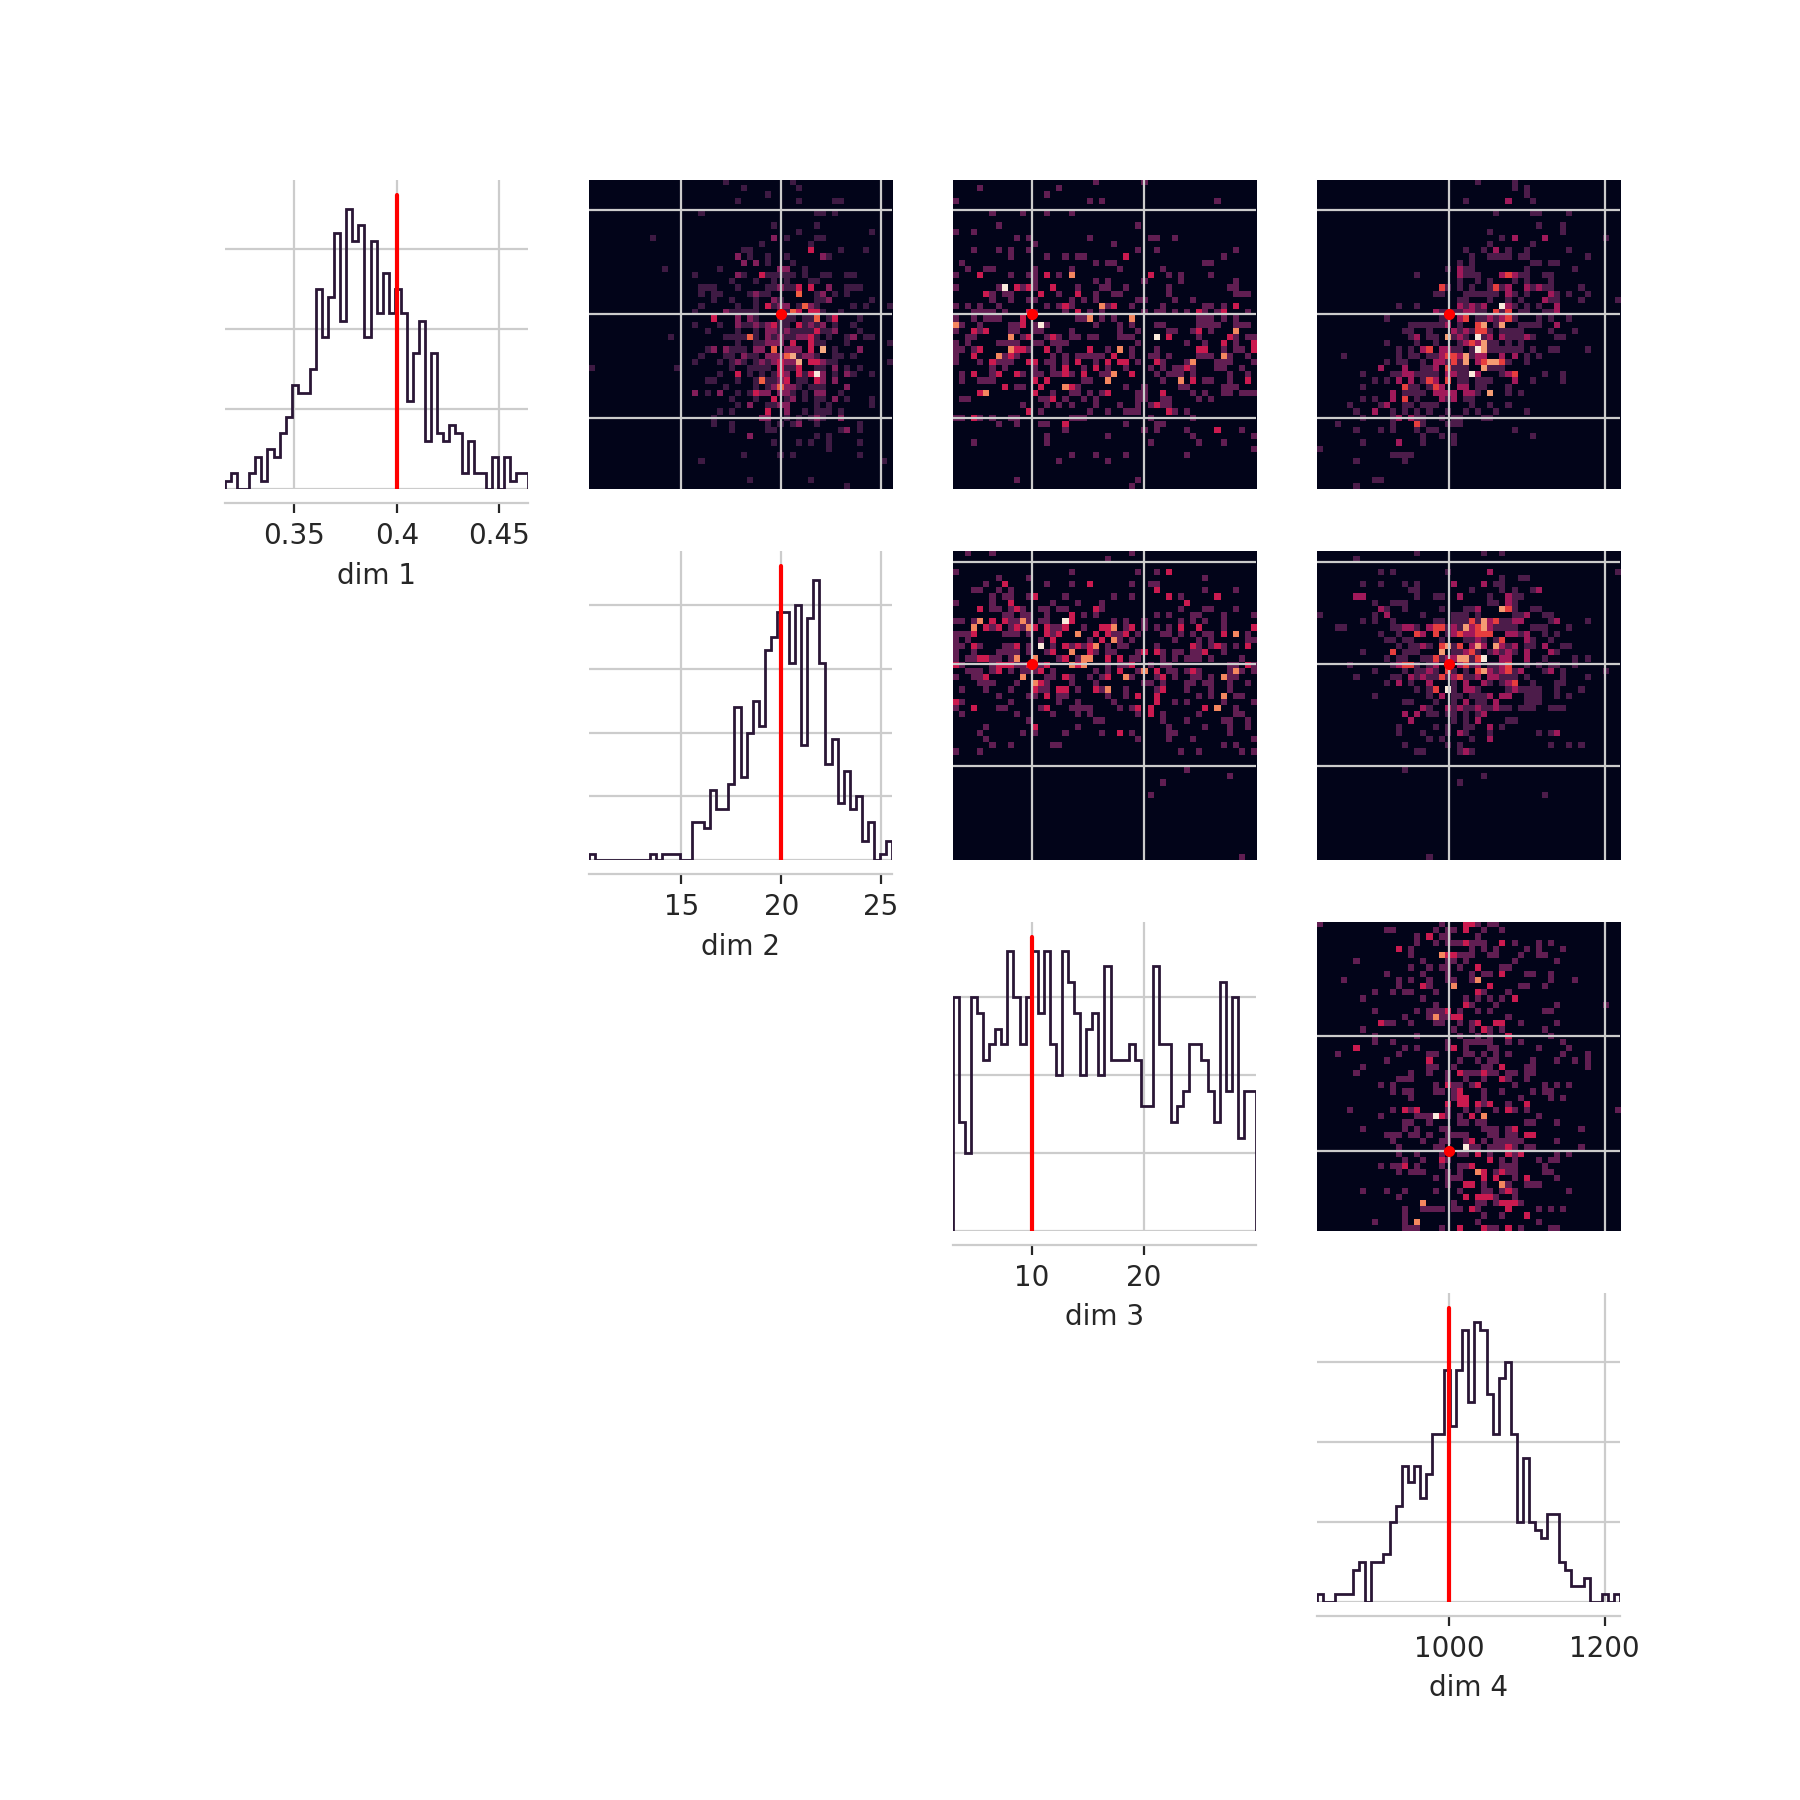

In [31]:
fig, axes = utils.pairplot(samples_snre,
                           #limits=[[.5,80], [1e-4,15.]],
                           #ticks=[[.5,80], [1e-4,15.]],
                           fig_size=(9,9),
                           points=np.array(param_obs),
                           points_offdiag={'markersize': 6},
                           points_colors='r');





<IPython.core.display.Javascript object>


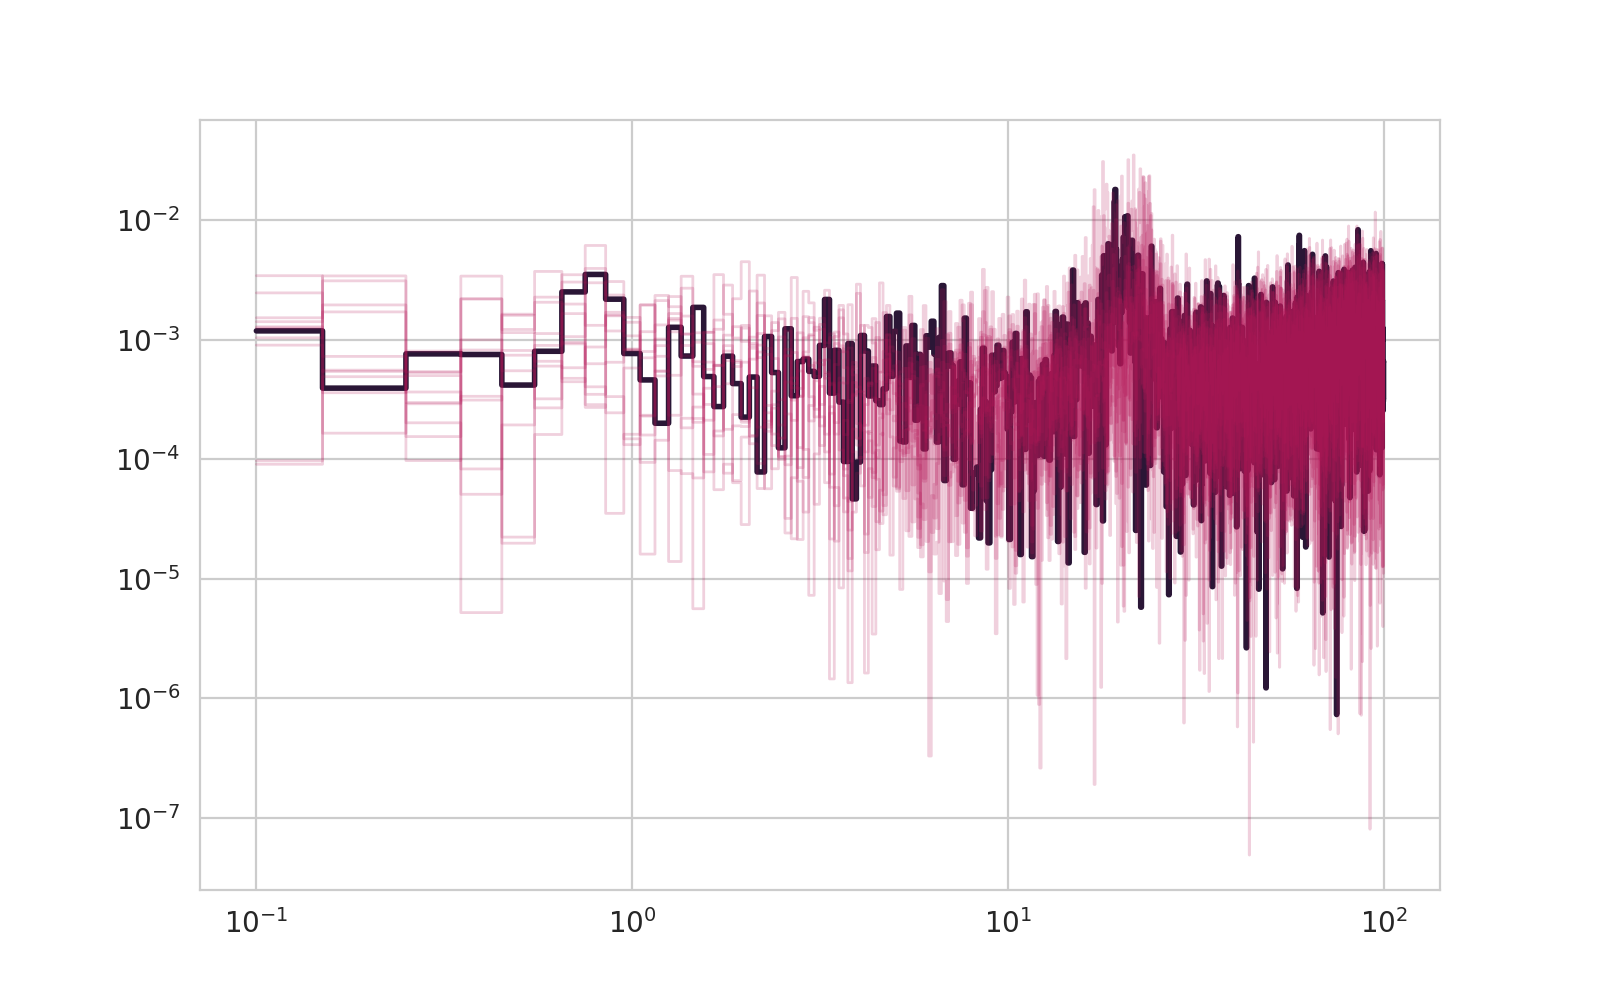

In [32]:
pal = sns.color_palette()

samples_snre = np.array(samples_snre)
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.loglog(ps_obs_dt.freq, ps_obs_dt.power, lw=2, color=pal[0], ds="steps-mid");

# plot simulations

nsim = 10
idx = np.random.choice(np.arange(0, samples_snle.shape[0], 1, dtype=int), replace=False, size=nsim)

for i in idx:
    param_sim = samples_snre[i,:]
    ps_sim = np.array(simulator(param_sim))
    
    ax.loglog(ps_obs_dt.freq, ps_sim, lw=1, color=pal[3], alpha=0.2, ds='steps-mid')
    